# Задача 3. Обнаружение неисправностей типа M1, вызвавших останов оборудования

In [1]:
import gc
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import os, sys
project_path = os.path.abspath('data/')

if project_path not in sys.path:
    sys.path.append(project_path)

import sys
from IPython.display import display, HTML

## Важные функции и загрузка данных

In [54]:
def get_cols(num):
    return [x for x in X_train.columns if f'ЭКСГАУСТЕР {num}.' in x]
def get_faults(num):
    return [x for x in y_train.columns if f'Y_ЭКСГАУСТЕР А/М №{num}' in x]

def rename_y_train_col(x):
    x = x.split('_')[2]
    pair = None
    if ' ЭКСГ.' in x:
        pair = x.split(' ЭКСГ.')
    elif ' ЭКСГАУСТЕРА' in x:
        pair = x.split(' ЭКСГАУСТЕРА')
    elif 'ЭКСГАУСТЕР А/М 'in x:
        pair = x.split(' А/М')
        pair[0] = pair[0] + '  А/М'
#         pair[-1] = pair[-1] + '__'
    elif ' ЭКСГ ' in x:
        pair = x.split(' ЭКСГ')

    if pair is not None:
        if len(pair)>2:
            raise
        try:
            x = pair[0] + pair[1].split('№')[1][1:]
        except:
            print(x)
    for num in nums:
        x = x.replace(f'ЭКСГ{num}','')
    return x

    
nums = [4,5,6,7,8,9]
len(nums)

6

### Загрузка обучающей и тестовой выборок

In [8]:
# !pip install fastparquet

In [80]:
X_train = pd.read_parquet(f'{project_path}/X_train.parquet')
X_test = pd.read_parquet(f'{project_path}/X_test.parquet')

X_train.columns = [x.replace('ТОК РОТОРА2', 'ТОК РОТОРА 2') for x in X_train.columns]
X_test.columns = [x.replace('ТОК РОТОРА2', 'ТОК РОТОРА 2') for x in X_test.columns]

In [81]:
y_train = pd.read_parquet(f'{project_path}/y_train.parquet').astype(np.int8)

### Загрузка данных ТОиР

In [55]:
from datetime import timedelta

In [56]:
toir_selected_m1_index =  pd.read_excel(f'{project_path}/Processed_toir2.xlsx')

In [57]:
mask = toir_selected_m1_index['Номер']

In [58]:
toir_selected_m1 = pd.read_excel(f'{project_path}/messages.xlsx', index_col='Unnamed: 0').loc[mask]

In [59]:
toir_selected_m1['ДАТА_НАЧАЛА_ИНТЕРВАЛА'] = toir_selected_m1['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'] - timedelta(days = 30)

In [60]:
toir_selected_m1['ИМЯ_МАШИНЫ'].value_counts()

ЭКСГАУСТЕР А/М №5    18
ЭКСГАУСТЕР А/М №8    11
ЭКСГАУСТЕР А/М №7     9
ЭКСГАУСТЕР А/М №4     8
ЭКСГАУСТЕР А/М №6     5
ЭКСГАУСТЕР А/М №9     3
Name: ИМЯ_МАШИНЫ, dtype: int64

In [61]:
toir_selected_m1.head(1)

,МАШИНА,ИМЯ_МАШИНЫ,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ВИД_СООБЩЕНИЯ,ОПИСАНИЕ,ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ,ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ,ТЕКСТ_ГРУППЫ_КОДОВ,ДАТА_НАЧАЛА_ИНТЕРВАЛА
478,CH-AGP-AG2/011-005,ЭКСГАУСТЕР А/М №9,CH-AGP-AG2/011-005-001-007-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9,M1,остановка эксгаустера защита двигателя,2019-03-19 14:00:16,2019-03-19 14:19:19,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,2019-02-17 14:00:16


### Работа с признаками

In [63]:
X_train.head(2)

,ЭКСГАУСТЕР 4. ТОК РОТОРА 1,ЭКСГАУСТЕР 4. ТОК РОТОРА 2,ЭКСГАУСТЕР 4. ТОК СТАТОРА,ЭКСГАУСТЕР 4. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ,...,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 1,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 2,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.
DT,,,,,,,,,,,,,,,,,,,,,
2019-01-16 13:21:00,363.676667,363.676667,244.0780,119.38500,41.370000,39.750000,39.750000,44.538548,33.260000,40.560000,...,17.040000,15.41,6.08500,12.170000,0.040000,0.060000,0.080000,0.100000,0.060000,0.08000
2019-01-16 13:21:10,363.103333,363.103333,243.0325,119.44444,41.374596,39.752083,39.995457,44.863054,33.343074,40.401081,...,16.063092,13.79,5.19211,12.574638,0.033854,0.065972,0.072917,0.086806,0.294271,0.09375


In [62]:
all_columns = X_train.columns

# создаем словарь с именами столбцов для каждого эксгаустера
col_names_dict_X = {}
for num in [f'ЭКСГАУСТЕР {i}' for i in nums]:
    col_names_dict_X[num] = [i for i in all_columns if f'{num}' in i]

In [64]:
# выбираем столбцы для одного эксгаустера
mask = col_names_dict_X['ЭКСГАУСТЕР 5']

In [65]:
print(f'У каждого эксгаустера {len(mask)} сигналов')

У каждого эксгаустера 16 сигналов


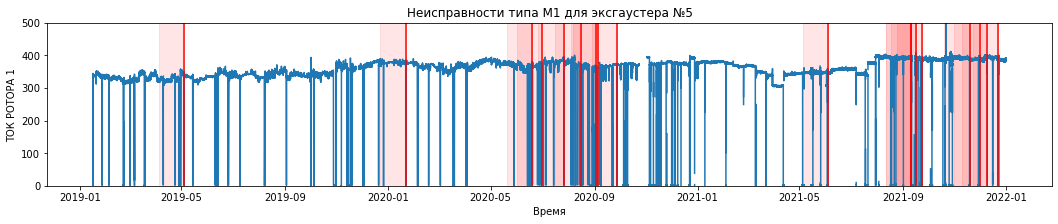

In [23]:
# markup = X_train[mask][y_train==1].any(axis=1)

m1 = toir_selected_m1[toir_selected_m1['ИМЯ_МАШИНЫ'] == 'ЭКСГАУСТЕР А/М №5']['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'].values
m1_healthy_again = toir_selected_m1[toir_selected_m1['ИМЯ_МАШИНЫ'] == 'ЭКСГАУСТЕР А/М №5']['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'].values

plt.figure(figsize=(18, 3))
plt.plot(X_train['ЭКСГАУСТЕР 5. ТОК РОТОРА 1'])
plt.ylim(0, 500)
plt.title('Неисправности типа М1 для эксгаустера №5')
plt.ylabel('ТОК РОТОРА 1')
plt.xlabel('Время')
for i in range(len(m1)):
    plt.axvline(m1[i], c='r')
    plt.axvspan(m1[i] - np.timedelta64(30,'D'), m1[i], color='r', alpha=0.1)
    plt.axvspan(m1[i], m1_healthy_again[i], color='yellow', alpha=0.1)

In [24]:
from tqdm import tqdm

In [25]:
# подготовка признаков, используемых в модели
mask = col_names_dict_X['ЭКСГАУСТЕР 5']

# если надо удалить признаки выборочно
# в данном случае удаляем признаки с большим числом пропусков
cols_exclude = ['ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1',
                'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2',
                'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3',
                'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ',
                'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ']
mask = [i for i in mask if i not in cols_exclude]

In [26]:
def fault_free_train_preparation(X=X_train, 
                                 toir_selected_m1=toir_selected_m1,
                                 mask=mask, 
                                 train_period_start=X_train.index[0], 
                                 train_period_end='2021-05-01'):
    # выбор признаков и интервала
    X_fault_free = X[mask][train_period_start:train_period_end]
    # подготовка данных
    X_fault_free = X_fault_free.fillna(method='pad', limit=60)
    X_fault_free = X_fault_free[(X_fault_free['ЭКСГАУСТЕР 5. ТОК РОТОРА 1']>50) |\
                                (X_fault_free['ЭКСГАУСТЕР 5. ТОК РОТОРА 2']>50) |\
                                (X_fault_free['ЭКСГАУСТЕР 5. ТОК СТАТОРА']>50)]
    X_fault_free = X_fault_free.dropna()
    
    m1 = toir_selected_m1[toir_selected_m1['ИМЯ_МАШИНЫ'] == 'ЭКСГАУСТЕР А/М №5']['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'].values
    m1_healthy_again = toir_selected_m1[toir_selected_m1['ИМЯ_МАШИНЫ'] == 'ЭКСГАУСТЕР А/М №5']['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'].values

    # удаляем интервалы [30 дней до начала м1; устранение м1]
    for i in tqdm(range(len(m1))):
        mask_to_drop = ((X_fault_free.index > m1[i] - np.timedelta64(30,'D')) & 
                        (X_fault_free.index < m1_healthy_again[i]))
        X_fault_free = X_fault_free.drop(X_fault_free.index[mask_to_drop])
    
    return X_fault_free

X_train_fault_free = fault_free_train_preparation()

100%|██████████| 18/18 [00:12<00:00,  1.42it/s]


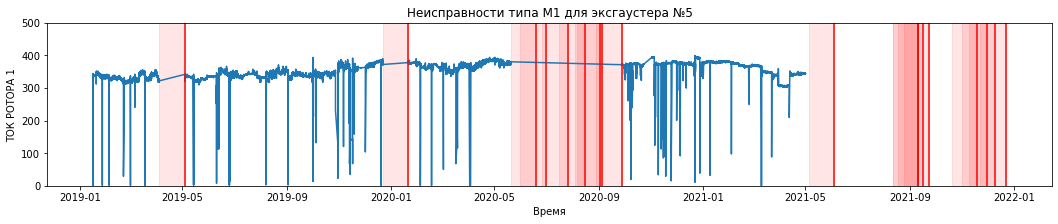

In [27]:
# markup = X_train[mask][y_train==1].any(axis=1)

m1 = toir_selected_m1[toir_selected_m1['ИМЯ_МАШИНЫ'] == 'ЭКСГАУСТЕР А/М №5']['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'].values
m1_healthy_again = toir_selected_m1[toir_selected_m1['ИМЯ_МАШИНЫ'] == 'ЭКСГАУСТЕР А/М №5']['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'].values

plt.figure(figsize=(18, 3))
plt.plot(X_train_fault_free['ЭКСГАУСТЕР 5. ТОК РОТОРА 1'])
plt.ylim(0, 500)
plt.title('Неисправности типа М1 для эксгаустера №5')
plt.ylabel('ТОК РОТОРА 1')
plt.xlabel('Время')
for i in range(len(m1)):
    plt.axvline(m1[i], c='r')
    plt.axvspan(m1[i] - np.timedelta64(30,'D'), m1[i], color='r', alpha=0.1)
    plt.axvspan(m1[i], m1_healthy_again[i], color='yellow', alpha=0.1)

Доля пропусков значений по признакам

In [28]:
X_train_fault_free.isna().sum() / len(X_train_fault_free) * 100

ЭКСГАУСТЕР 5. ТОК РОТОРА 1                        0.0
ЭКСГАУСТЕР 5. ТОК РОТОРА 2                        0.0
ЭКСГАУСТЕР 5. ТОК СТАТОРА                         0.0
ЭКСГАУСТЕР 5. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ            0.0
ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 1                 0.0
ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 2                 0.0
ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3                 0.0
ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.    0.0
ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4                 0.0
ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.    0.0
dtype: float64

In [29]:
# удаление строк с пропусками, если такие остаются
num_of_features_wo_nan = len(X_train_fault_free.columns)
X_train_fault_free.dropna(thresh=num_of_features_wo_nan, inplace=True)

## Подход 1. Прогноз индекса технического состояния

In [136]:
from t2 import T2

In [188]:
t2 = T2(scaling=True, using_pca=False)

In [189]:
t2.fit(X_train_fault_free)

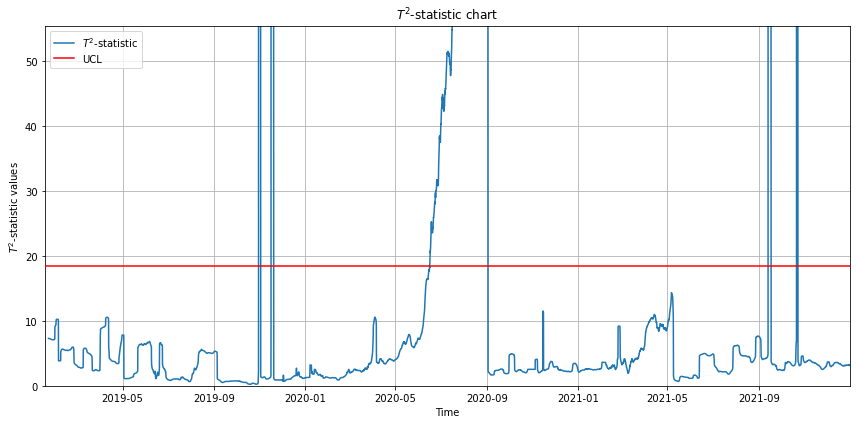

/Users/iurii/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


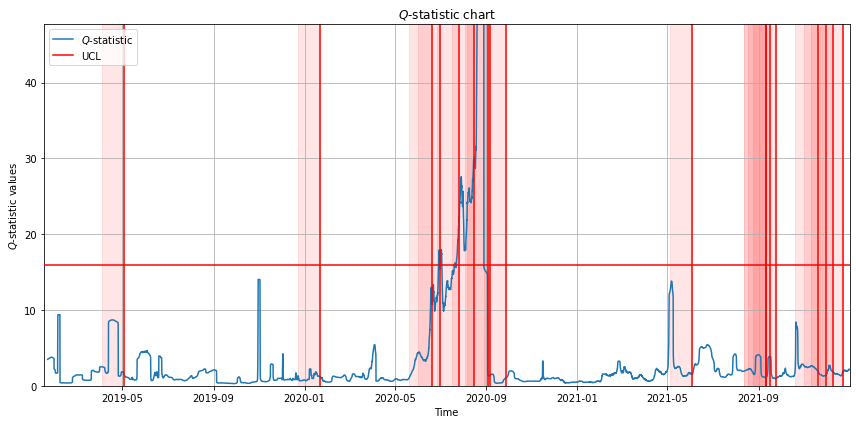

In [187]:
t2.predict(X_train[mask].fillna(method='ffill'), window_size=60*60*12)
for i in range(len(m1)):
    plt.axvline(m1[i], c='r')
    plt.axvspan(m1[i] - np.timedelta64(30,'D'), m1[i], color='r', alpha=0.1)
    plt.axvspan(m1[i], m1_healthy_again[i], color='yellow', alpha=0.1)

/Users/iurii/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


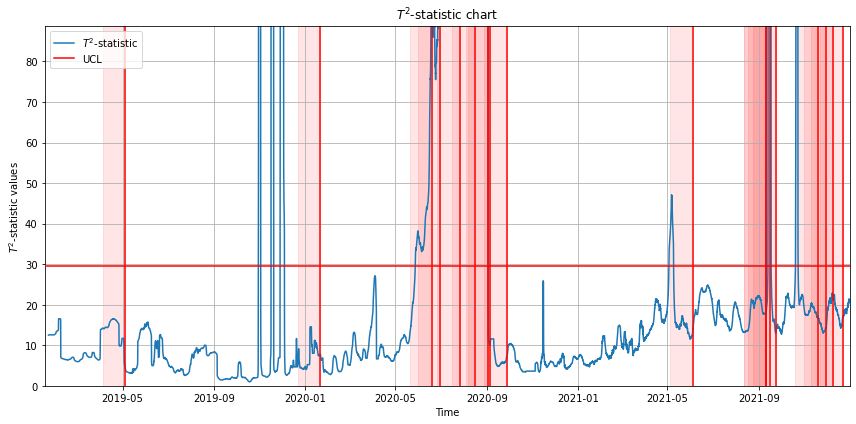

In [191]:
t2.predict(X_train[mask].fillna(method='ffill'), window_size=60*60*12)
for i in range(len(m1)):
    plt.axvline(m1[i], c='r')
    plt.axvspan(m1[i] - np.timedelta64(30,'D'), m1[i], color='r', alpha=0.1)
    plt.axvspan(m1[i], m1_healthy_again[i], color='yellow', alpha=0.1)

## Подход 2. Регрессия

In [97]:
from tsfresh.feature_extraction import MinimalFCParameters, extract_features

In [ ]:
# X_train # обучающая выборка
# toir_selected_m1 # журнал от Славы почищенный

### Подготовка данных для обучения моделей

In [20]:
all_columns = X_train.columns

# создаем словарь с именами столбцов для каждого эксгаустера
col_names_dict_X = {}
for num in [f'ЭКСГАУСТЕР {i}' for i in nums]:
    col_names_dict_X[num] = [i for i in all_columns if f'{num}' in i]

# создаем интервалы в 60 дней до М1 для моделей регрессии
toir_selected_m1['ДАТА_НАЧАЛА_ИНТЕРВАЛА'] = toir_selected_m1['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'] - timedelta(days = 60)

# Приводим названия эксгаустеров в файле ТОиР к таким же названиям
toir_selected_m1['ИМЯ_МАШИНЫ'] = toir_selected_m1['ИМЯ_МАШИНЫ'].str.replace('А/М №', '')

In [82]:
def sliding_window_df_preparation(X, window=7*24):
    '''
    Функция для нарезки датасета (трейн и тест)
    на 7ми дневные интервалы, каждому из которых соответствует 
    ответ - время до неисправности
    
    X: pd.DataFrame, датасет ресэмплирован до 1 события в час
    '''
    X_tr = []
    for i in range(len(X)):
        # find the end of this pattern
        end_ix = i + window
        # check if we are beyond the dataset
        if end_ix > len(X)-1:
            break
        # gather input and output parts of the pattern
        seq_x = X.iloc[i:end_ix+1, :]#, X.iloc[end_ix, -1]
        X_tr.append(seq_x)
        # y_tr.append(seq_y)
    return X_tr#, y_tr

def preprocessing_task3(X):
    X = X.copy()
    # ресемплирование
    X = X.resample('H').median()
    
    # очистка данных
    X = X.fillna(method='pad', limit=1)
    X = X.dropna()
    
    # удаление наименования эксгаустера из названия столбцов
    X.columns = [i[14:] if 'ЭКС' in i else i for i in X.columns]
    return X

In [110]:
X_final = []

settings = MinimalFCParameters()
# идем по эксгаустерам
for key in tqdm(col_names_dict_X.keys()):
    # выбираем столбцы для одного эксгаустера
    mask = col_names_dict_X[key]
    # идем по неисправностям
    for i in range(len(toir_selected_m1)):
        X = X_train[mask][toir_selected_m1.iloc[i]['ДАТА_НАЧАЛА_ИНТЕРВАЛА']:
                            toir_selected_m1.iloc[i]['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ']]
        
        # предварительная обработка данных
        X = preprocessing_task3(X)
        
        # создаем колонку с остаточным ресурсом в секундах
        X['RUL'] = (toir_selected_m1.iloc[i]['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'] - X.index).total_seconds()
        X_tr = sliding_window_df_preparation(X=X.drop(['RUL'], axis=1))
        y_tr = X['RUL'][7*24:].to_list()
        
        for j in range(len(X_tr)):
            X_tr[j]['id'] = str(j)
        extracted_features = extract_features(pd.concat(X_tr), column_id="id", default_fc_parameters=settings)
        extracted_features['RUL'] = y_tr
        
        X_final.append(extracted_features)

Feature Extraction: 100%|██████████| 25/25 [00:03<00:00,  7.67it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  8.48it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  8.90it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  8.87it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  9.00it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  8.86it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  8.45it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  8.86it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  8.75it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s]

Feature Extraction: 100%|██████████| 25/25 [00:02<00:00,  8.94it/s]

Feature Extraction: 100%|█████████

In [121]:
X_final = pd.concat(X_final)

In [67]:
# X_final.to_csv('final_df_for_train.csv')

X_final = pd.read_csv('final_df_for_train.csv')

In [68]:
X_final = X_final.drop(['Unnamed: 0'], axis=1)
X_final.head()

,ТОК РОТОРА 1__sum_values,ТОК РОТОРА 1__median,ТОК РОТОРА 1__mean,ТОК РОТОРА 1__length,ТОК РОТОРА 1__standard_deviation,ТОК РОТОРА 1__variance,ТОК РОТОРА 1__root_mean_square,ТОК РОТОРА 1__maximum,ТОК РОТОРА 1__absolute_maximum,ТОК РОТОРА 1__minimum,...,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.__median,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.__mean,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.__length,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.__standard_deviation,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.__variance,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.__root_mean_square,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.__maximum,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.__absolute_maximum,ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.__minimum,RUL
0,62631.216583,377.715000,370.598915,169.0,18.409310,338.902693,371.055869,390.7500,390.7500,317.212500,...,1.052951,1.022878,169.0,0.097916,0.009588,1.027553,1.190000,1.190000,0.775463,1965616.0
1,62609.132083,377.655000,370.468237,169.0,18.374536,337.623576,370.923629,390.7500,390.7500,317.212500,...,1.052951,1.023233,169.0,0.097760,0.009557,1.027892,1.190000,1.190000,0.775463,1962016.0
2,62411.780986,375.115833,369.300479,169.0,18.023287,324.838871,369.740021,390.7500,390.7500,317.212500,...,1.052951,1.032691,169.0,0.086639,0.007506,1.036319,1.190000,1.190000,0.805556,1958416.0
3,62644.696466,372.563000,370.678677,169.0,10.435280,108.895068,370.825534,385.4025,385.4025,338.892333,...,1.108507,1.090271,169.0,0.103328,0.010677,1.095157,1.237461,1.237461,0.805556,1954816.0
4,62638.737716,372.563000,370.643418,169.0,10.395462,108.065633,370.789171,384.6625,384.6625,338.892333,...,1.108507,1.090191,169.0,0.103271,0.010665,1.095071,1.237461,1.237461,0.805556,1951216.0


### Обучение моделей

In [130]:
# !pip install pandas==1.5.3

In [23]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tsfresh.feature_selection import select_features

In [69]:
# selected_features = select_features(X_final.drop(['RUL'], axis=1), X_final['RUL']).columns.to_list() + ['RUL']
# X_final = X_final[selected_features]

#### Catboost

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_final.drop(['RUL'], axis=1), X_final['RUL'], shuffle=True, random_state=1)

In [71]:
cbr = CatBoostRegressor(random_state=1)

In [72]:
cbr.fit(X_train, y_train)

/Users/iurii/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.088237
0:	learn: 570959.6108342	total: 24.4ms	remaining: 24.3s
1:	learn: 568682.4790400	total: 35ms	remaining: 17.5s
2:	learn: 567251.6103492	total: 45.5ms	remaining: 15.1s
3:	learn: 565659.6146790	total: 57ms	remaining: 14.2s
4:	learn: 564445.8306090	total: 68.2ms	remaining: 13.6s
5:	learn: 563312.2544176	total: 80.1ms	remaining: 13.3s
6:	learn: 562426.7559113	total: 90.2ms	remaining: 12.8s
7:	learn: 561244.8404755	total: 101ms	remaining: 12.5s
8:	learn: 560158.3018011	total: 112ms	remaining: 12.4s
9:	learn: 559245.8368540	total: 123ms	remaining: 12.2s
10:	learn: 558335.0426943	total: 133ms	remaining: 12s
11:	learn: 557677.1957183	total: 144ms	remaining: 11.9s
12:	learn: 556397.1501472	total: 155ms	remaining: 11.8s
13:	learn: 555511.4703174	total: 165ms	remaining: 11.6s
14:	learn: 554432.7384889	total: 177ms	remaining: 11.6s
15:	learn: 553448.7561136	total: 189ms	remaining: 11.6s
16:	learn: 552771.2796788	total: 201ms	remaining: 11.6s
17:	learn: 551582.9538645	t

In [37]:
y_pred = cbr.predict(X_test)

In [38]:
mean_squared_error(y_test, y_pred, squared=False)

431271.42436998896

In [40]:
431271 / 3600 / 24

4.9915625

In [73]:
cbr.save_model('cbr_task3')

#### linear regression

In [14]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [18]:
StSc = StandardScaler()
StSc.fit(X_train)

X_train_sc = StSc.transform(X_train)
X_test_sc = StSc.transform(X_test)

In [41]:
lasso = Lasso(random_state=1)

In [42]:
lasso.fit(X_train_sc, y_train)

/Users/iurii/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e+16, tolerance: 4.233e+12
  model = cd_fast.enet_coordinate_descent(


Lasso(random_state=1)

In [43]:
y_pred = lasso.predict(X_test_sc)

In [44]:
mean_squared_error(y_test, y_pred, squared=False)

565956.7555533764

### Инференс для заполнения файла

In [ ]:
def sliding_window_df_preparation(X, window=7*24):
    '''
    Функция для нарезки датасета (трейн и тест)
    на 7ми дневные интервалы, каждому из которых соответствует 
    ответ - время до неисправности
    
    X: pd.DataFrame, датасет ресэмплирован до 1 события в час
    '''
    X_tr = []
    for i in range(len(X)):
        # find the end of this pattern
        end_ix = i + window
        # check if we are beyond the dataset
        if end_ix > len(X)-1:
            break
        # gather input and output parts of the pattern
        seq_x = X.iloc[i:end_ix+1, :]#, X.iloc[end_ix, -1]
        X_tr.append(seq_x)
        # y_tr.append(seq_y)
    return X_tr#, y_tr

In [104]:
from tsfresh.feature_extraction import MinimalFCParameters, extract_features
import pandas as pd
from catboost import CatBoostRegressor

def preprocessing_task3(X):
    X = X.copy()
    X.index = pd.to_datetime(X.index)
    # ресемплирование
    X = X.resample('H').median()
    
    # очистка данных
    X = X.fillna(method='pad', limit=1)
    X = X.dropna()
    
    # удаление наименования эксгаустера из названия столбцов
    X.columns = [i[14:] if 'ЭКС' in i else i for i in X.columns]
    return X

def predict(X):
    '''
    Функция для инференса модели.
    На вход подается датафрейм по 1 эксгаустеру, содержащий следующие параметры:
    ТОК РОТОРА 1
    ТОК РОТОРА 2
    ТОК СТАТОРА
    ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ
    ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1
    ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2
    ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3
    ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4
    ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ
    ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ
    ВИБРАЦИЯ НА ОПОРЕ 1
    ВИБРАЦИЯ НА ОПОРЕ 2
    ВИБРАЦИЯ НА ОПОРЕ 3
    ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.
    ВИБРАЦИЯ НА ОПОРЕ 4
    ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.
    
    Длительность периода данных должна быть не менее 7 предыдущих дней.
    
    X: pd.DataFrame
    '''
    # предварительная обработка данных
    X = preprocessing_task3(X)
    # выбор данных за 7 дней (если подан больший интервал)
    X = X.iloc[-7*24:]
    # выделение признаков с помощью tsfresh
    X['id'] = '1'
    settings = MinimalFCParameters()
    extracted_features = extract_features(X, column_id="id", default_fc_parameters=settings)
    # загрузка модели
    cbr = CatBoostRegressor()
    cbr.load_model('cbr_task3')
    # инференс модели
    y_pred = cbr.predict(extracted_features)
    return y_pred

In [50]:
y_pred = pd.read_parquet(f'{project_path}/sample_submission/sample_submission_3.parquet')

In [85]:
from tqdm import tqdm

In [ ]:
settings = MinimalFCParameters()
# идем по эксгаустерам
for key in tqdm(col_names_dict_X.keys()):
    # выбираем столбцы для одного эксгаустера
    mask = col_names_dict_X[key]
    
    X_exg = X_test[mask].copy
    
    for i in range(len(X_test)):
        # find the end of this pattern
        end_ix = i + 6*60*24*7
        # check if we are beyond the dataset
        if end_ix > len(X_test)-1:
            break
        # gather input and output parts of the pattern
        seq_x = X_test[mask].iloc[i:end_ix+1, :]
        X_test.loc[X_test.index[end_ix], f'exg {i}'] = predict(seq_x)
        

Feature Extraction: 100%|██████████| 16/16 [00:02<00:00,  5.97it/s][A
/Users/iurii/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,

Feature Extraction: 100%|██████████| 16/16 [00:02<00:00,  7.68it/s][A
/Users/iurii/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,

Feature Extraction: 100%|██████████| 16/16 [00:02<00:00,  7.39it/s][A
/Users/iurii/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_p

## Работа с таргетом

In [38]:
all_columns = y_train.columns

# создаем словарь с именами столбцов для каждого эксгаустера
col_names_dict_y = {}
for num in nums:
    col_names_dict[num] = [i for i in all_columns if f'№{num}' in i]

In [25]:
# выбираем столбцы для одного эксгаустера
mask = col_names_dict[4]

# общее количество моментов времени с М1 для одного эксгаустера
y_train[mask][y_train==1].any(axis=1).sum()

6258

In [37]:
print(f'У каждого эксгаустера {len(mask)} типа неисправностей')

У каждого эксгаустера 23 типа неисправностей


## RUL baseline

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
import numpy as np
from sklearn.utils import check_array, check_consistent_length
from sklearn.metrics._regression import _check_reg_targets

def WRMSE(
    y_true, 
    y_pred, 
    alpha=1,
    multioutput="uniform_average"
    ):
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput
    )
    w = 1 / (alpha * y_true)
    return np.sum(w * (y_true - y_pred) ** 2, axis=0) / len(y_true)

In [37]:
mean_squared_error([1,2,4,6],[2,4,7,9])

5.75

In [38]:
WRMSE([1,2,4,6],[2,4,7,9])

array([5.75])